# Account

* 계좌 관리용 클래스
* 간단한 함수 설명
  - get_state 함수에서 environment에 추가할 계좌 state를 넘겨준다. 현재는 현금 비율과 초기 자본대비 수익률만 반환한다.
  - act의 반환값은 현금이 없는데 매수를 하거나 주식이 없는데 매도를 하면 -1을 반환 그 외에는 현재 수익률을 반환한다.

In [1]:
from typing import List, Dict
import numpy as np
import random
import seaborn as sns

class Action:
    # 행동
    ACTION_BUY = 0  # 매수
    ACTION_SELL = 1  # 매도
    ACTION_HOLD = 2  # 관망
    
    NUM_ACTIONS=3
    
    TABLE = {0: "ACTION_BUY", 1: "ACTION_SELL", 2: "ACTION_HOLD"}
    
    
class Account:
    # 매매 수수료 및 세금
    TRADING_CHARGE = 0.00015  # 거래 수수료 0.015%
    # TRADING_CHARGE = 0.00011  # 거래 수수료 0.011%
    # TRADING_CHARGE = 0  # 거래 수수료 미적용
    TRADING_TAX = 0.0025  # 거래세 0.25%
    # TRADING_TAX = 0  # 거래세 미적용
    
    def __init__(self, 
                 initial_balance: int, 
                 max_trading_price: int = 1500000, 
                 min_trading_price: int = 300):
        self.initial_balance = initial_balance
        self.balance = initial_balance

        # 최소 단일 매매 금액, 최대 단일 매매 금액
        self.min_trading_price = min_trading_price
        self.max_trading_price = max_trading_price
        
        self.num_stocks = 0
        # 포트폴리오 가치: balance + num_stocks * {현재 주식 가격}
        self.portfolio_value = initial_balance
        self.num_buy = 0  # 매수 횟수
        self.num_sell = 0  # 매도 횟수
        self.num_hold = 0  # 관망 횟수

        self.ratio_hold = 0  # 주식 보유 비율
        self.profitloss = 0  # 현재 손익
        self.avg_buy_price = 0  # 주당 매수 단가
    
    def reset(self):
        self.balance = self.initial_balance
        self.num_stocks = 0
        self.portfolio_value = self.initial_balance
        self.num_buy = 0
        self.num_sell = 0
        self.num_hold = 0
        self.ratio_hold = 0
        self.profitloss = 0
        self.avg_buy_price = 0
        
    def get_state(self):
        # 계좌에 대한 상태값을 반환한다
        ret = []
        ret.append(self.balance/self.initial_balance) # 현금 비율
        ret.append(self.profitloss) # 초기 자본 대비 수익률
        return ret
    
    def _validate_action(self, action, cur_price):
        if action == Action.ACTION_BUY:
            if self.balance < cur_price * (1 + Account.TRADING_CHARGE):
                return False
        elif action == Action.ACTION_SELL:
            if self.num_stocks <= 0:
                return False
        return True

    def decide_trading_unit(self, confidence, cur_price):
        # 거래 수량을 결정하자!
        if np.isnan(confidence):
            return max(int(self.min_trading_price / cur_price), 1)
        
        # 최소 거래 금액 + 신뢰도 만큼 추가 구매
        added_trading_price = max(
            int(confidence * (self.max_trading_price - self.min_trading_price)), 0)
        trading_price = self.min_trading_price + added_trading_price
        return max(int(trading_price / cur_price), 1)
    
    def act(self, action, cur_price, action_confidence):
        # 행동에 따라서 매수 또는 매도를 진행한다.
        if not self._validate_action(action, cur_price):
            return -1
            
        trading_unit = self.decide_trading_unit(action_confidence, cur_price)
        
        # 매수
        if action == Action.ACTION_BUY:
            # 매수할 단위를 판단
            balance = (
                self.balance - cur_price *
                (1 + Account.TRADING_CHARGE) * trading_unit
            )
            # 보유 현금이 모자랄 경우 보유 현금으로 가능한 만큼 최대한 매수
            if balance < 0:
                trading_unit = min(
                    int(self.balance / (cur_price * (1 + Account.TRADING_CHARGE))),
                    int(self.max_trading_price / cur_price)
                )
            # 수수료를 적용하여 총 매수 금액 산정
            invest_amount = cur_price * (1 + Account.TRADING_CHARGE) * trading_unit
            if invest_amount > 0:
                self.avg_buy_price = \
                    (self.avg_buy_price * self.num_stocks + cur_price * trading_unit) \
                        / (self.num_stocks + trading_unit)  # 주당 매수 단가 갱신
                self.balance -= invest_amount  # 보유 현금을 갱신
                self.num_stocks += trading_unit  # 보유 주식 수를 갱신
                self.num_buy += 1  # 매수 횟수 증가

        # 매도
        elif action == Action.ACTION_SELL:
            # 보유 주식이 모자랄 경우 가능한 만큼 최대한 매도
            trading_unit = min(trading_unit, self.num_stocks)
            # 매도
            invest_amount = cur_price * (
                1 - (Account.TRADING_TAX + Account.TRADING_CHARGE)) * trading_unit
            if invest_amount > 0:
                # 주당 매수 단가 갱신
                self.avg_buy_price = \
                    (self.avg_buy_price * self.num_stocks - cur_price * trading_unit) \
                        / (self.num_stocks - trading_unit) \
                            if self.num_stocks > trading_unit else 0
                self.num_stocks -= trading_unit  # 보유 주식 수를 갱신
                self.balance += invest_amount  # 보유 현금을 갱신
                self.num_sell += 1  # 매도 횟수 증가

        # 관망
        elif action == Action.ACTION_HOLD:
            self.num_hold += 1  # 관망 횟수 증가

        # 포트폴리오 가치 갱신
        self.portfolio_value = self.balance + cur_price * self.num_stocks
        self.profitloss = self.portfolio_value / self.initial_balance - 1
        return self.profitloss
        

In [2]:
# account test
test_account = Account(3000000)

In [3]:
import random

for _ in range(10):
    rand_action = random.randrange(0,Action.NUM_ACTIONS)
    rand_price = random.randrange(20000,200000)
    rand_confidence = random.random()
    test_account.act(rand_action, rand_price, rand_confidence)

In [4]:
print(f"{test_account.balance:7.2}")

1.6e+06


In [5]:
test_account.num_buy, test_account.num_sell, test_account.num_hold, test_account.initial_balance, test_account.portfolio_value, test_account.profitloss

(2, 1, 3, 3000000, 2977373.1489500003, -0.007542283683333206)

In [6]:
test_account.get_state()

[0.5479843829833334, -0.007542283683333206]

# Data control

In [9]:
import pandas as pd

In [13]:
ticker = pd.read_csv("data/v3/005380_hyundai.csv")
market = pd.read_csv("data/v3/marketfeatures.csv")

In [14]:
ticker.head(5)

,date,open,high,low,close,volume,per,pbr,roe,open_lastclose_ratio,...,inst_ma20,inst_ma60,inst_ma120,foreign,foreign_diff,foreign_ma5,foreign_ma10,foreign_ma20,foreign_ma60,foreign_ma120
0,20180102,150500,153000,149000,149500,731763,7.93,0.64,8.93,-0.035256,...,0.006821,-0.004487,-0.010062,-0.028687,0.030152,0.008988,-0.000355,0.018946,0.059708,0.011424
1,20180103,149000,151000,149000,150500,450874,7.93,0.64,8.93,-0.003344,...,-0.004508,-0.008656,-0.010283,0.185194,0.213881,0.017767,0.008839,0.019816,0.059380,0.012394
2,20180104,150500,151000,146000,146500,931558,7.93,0.64,8.93,0.000000,...,-0.023628,-0.018314,-0.011738,0.335811,0.150617,0.083100,0.040954,0.028696,0.058292,0.012535
3,20180105,146000,149000,145500,149000,463695,7.93,0.64,8.93,-0.003413,...,-0.037289,-0.018647,-0.011764,0.187554,-0.148256,0.124207,0.063475,0.037053,0.054398,0.013243
4,20180108,148500,151000,147500,151000,482619,7.93,0.64,8.93,-0.003356,...,-0.032379,-0.020008,-0.011351,0.393153,0.205598,0.214605,0.112976,0.042058,0.055951,0.017437


In [15]:
market.head(5)

,date,market_kospi_ma5_ratio,market_kospi_ma20_ratio,market_kospi_ma60_ratio,market_kospi_ma120_ratio,bond_k3y_ma5_ratio,bond_k3y_ma20_ratio,bond_k3y_ma60_ratio,bond_k3y_ma120_ratio
0,20180101,0.011111,-0.000271,-0.009638,0.011878,0.000425,-0.001435,-0.002387,-0.006522
1,20180102,0.011962,0.004589,-0.005469,0.016520,0.000185,-0.001440,-0.002541,-0.006709
2,20180103,0.010917,0.007081,-0.003536,0.018925,0.000222,-0.000942,-0.002202,-0.006400
3,20180104,-0.000350,-0.000263,-0.011983,0.010503,0.000444,-0.000379,-0.001773,-0.005997
4,20180105,0.007270,0.012585,0.000034,0.022817,0.000416,0.000076,-0.001460,-0.005701


* ticker 개별 종목에 대한 정보들을 갖고 있다.
  - 날짜, 시작가, 최고가, 최저가, 종가, 거래량, per, pbr, roe, 5~60일 평균 대비 현재가 비율 등등
* market
  - kospi 5~60일 평균 대비 현재가 비율, 채권 등등에 대한 정보

In [14]:
input_df = pd.merge(ticker, market, on="date")
input_df = input_df.sort_values(by='date')

In [15]:
CHART_COLS=["date", "open", "high", "low", "close", "volume"]

def split_chart_value_df(df):
    # chart 형 변수와 기업 가치 변수로 분리
    chart_df = df[CHART_COLS]
    value_df = df.drop(CHART_COLS, axis=1)
    return chart_df, value_df

def split_train_test_df(df, date=20201231):
    # 날짜 기준으로 데이터 분리
    train_df = df[df["date"] <= date]
    test_df = df[df["date"] > date]
    return train_df, test_df

In [16]:
chart_df, value_df = split_chart_value_df(input_df)
value_df.describe()

,per,pbr,roe,open_lastclose_ratio,high_close_ratio,low_close_ratio,diffratio,volume_lastvolume_ratio,close_ma5_ratio,volume_ma5_ratio,...,foreign_ma60,foreign_ma120,market_kospi_ma5_ratio,market_kospi_ma20_ratio,market_kospi_ma60_ratio,market_kospi_ma120_ratio,bond_k3y_ma5_ratio,bond_k3y_ma20_ratio,bond_k3y_ma60_ratio,bond_k3y_ma120_ratio
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,...,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,7.931572,0.639158,8.912323,0.000507,0.014723,-0.013745,0.000552,0.121023,0.000750,0.005767,...,-0.034298,-0.033147,0.000443,0.002150,0.006176,0.013840,0.000028,0.000123,0.000296,0.000532
std,0.077442,0.005274,0.069882,0.013034,0.012888,0.013055,0.022827,0.642281,0.026772,0.362107,...,0.050992,0.039514,0.013654,0.032049,0.057154,0.080203,0.000966,0.002093,0.003411,0.004914
min,7.190000,0.580000,8.560000,-0.089474,0.000000,-0.111765,-0.103401,-0.796569,-0.154261,-0.671558,...,-0.129050,-0.101543,-0.112016,-0.243443,-0.309603,-0.307993,-0.004965,-0.007106,-0.014047,-0.016574
25%,7.930000,0.640000,8.930000,-0.004283,0.006742,-0.018683,-0.011300,-0.233977,-0.012636,-0.255953,...,-0.075668,-0.061340,-0.006064,-0.011221,-0.026278,-0.040768,-0.000442,-0.001091,-0.001631,-0.002769
50%,7.930000,0.640000,8.930000,0.000000,0.012000,-0.009934,0.000000,-0.013626,-0.000601,-0.064159,...,-0.033147,-0.034446,0.001746,0.003220,0.004335,0.003960,0.000117,0.000311,0.000477,0.000605
75%,7.930000,0.640000,8.930000,0.006187,0.019672,-0.004709,0.010582,0.294665,0.012451,0.169729,...,-0.001948,-0.013780,0.007907,0.017397,0.032651,0.055918,0.000560,0.001502,0.002389,0.003912
max,8.490000,0.660000,8.960000,0.167476,0.151745,0.000000,0.194175,7.043177,0.181537,1.937052,...,0.082122,0.072145,0.089863,0.110429,0.212105,0.277663,0.003352,0.005930,0.009782,0.012477


* per, pbr, roe 값이 다른 값들에 비해 큰 값을 갖는다.

In [17]:
input_df[["per", "pbr", "roe"]] = input_df[["per", "pbr", "roe"]].apply(lambda x: x/100)

In [18]:
chart_df, value_df = split_chart_value_df(input_df)
value_df.describe()

,per,pbr,roe,open_lastclose_ratio,high_close_ratio,low_close_ratio,diffratio,volume_lastvolume_ratio,close_ma5_ratio,volume_ma5_ratio,...,foreign_ma60,foreign_ma120,market_kospi_ma5_ratio,market_kospi_ma20_ratio,market_kospi_ma60_ratio,market_kospi_ma120_ratio,bond_k3y_ma5_ratio,bond_k3y_ma20_ratio,bond_k3y_ma60_ratio,bond_k3y_ma120_ratio
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,...,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,0.079316,0.006392,0.089123,0.000507,0.014723,-0.013745,0.000552,0.121023,0.000750,0.005767,...,-0.034298,-0.033147,0.000443,0.002150,0.006176,0.013840,0.000028,0.000123,0.000296,0.000532
std,0.000774,0.000053,0.000699,0.013034,0.012888,0.013055,0.022827,0.642281,0.026772,0.362107,...,0.050992,0.039514,0.013654,0.032049,0.057154,0.080203,0.000966,0.002093,0.003411,0.004914
min,0.071900,0.005800,0.085600,-0.089474,0.000000,-0.111765,-0.103401,-0.796569,-0.154261,-0.671558,...,-0.129050,-0.101543,-0.112016,-0.243443,-0.309603,-0.307993,-0.004965,-0.007106,-0.014047,-0.016574
25%,0.079300,0.006400,0.089300,-0.004283,0.006742,-0.018683,-0.011300,-0.233977,-0.012636,-0.255953,...,-0.075668,-0.061340,-0.006064,-0.011221,-0.026278,-0.040768,-0.000442,-0.001091,-0.001631,-0.002769
50%,0.079300,0.006400,0.089300,0.000000,0.012000,-0.009934,0.000000,-0.013626,-0.000601,-0.064159,...,-0.033147,-0.034446,0.001746,0.003220,0.004335,0.003960,0.000117,0.000311,0.000477,0.000605
75%,0.079300,0.006400,0.089300,0.006187,0.019672,-0.004709,0.010582,0.294665,0.012451,0.169729,...,-0.001948,-0.013780,0.007907,0.017397,0.032651,0.055918,0.000560,0.001502,0.002389,0.003912
max,0.084900,0.006600,0.089600,0.167476,0.151745,0.000000,0.194175,7.043177,0.181537,1.937052,...,0.082122,0.072145,0.089863,0.110429,0.212105,0.277663,0.003352,0.005930,0.009782,0.012477


# Environment

In [19]:
class Environment:
    def __init__(self, chart_df, value_df, account):
        self.chart_df = chart_df
        self.value_df = value_df
        self.account = account
        self.cur_index = 0
        self.done = False

        self.env_state_len = len(self.reset())

    def reset(self):
        # print("env reset")
        self.done = False
        self.cur_index = 0
        state = self._get_state()
        return state

    def _get_state(self):
        value_state = value_df.iloc[self.cur_index].to_list()
        account_state = self.account.get_state()
        # print(f"value state: {value_state}")
        # print(f"account state: {account_state}")
        value_state.extend(account_state)
        return value_state

    def step(self, action, action_confidence):
        self.cur_index += 1
        cur_price = int(chart_df.iloc[self.cur_index]['close'])

        # job done check
        if len(self.value_df) - 1 == self.cur_index:
            self.done = True
        
        state = self._get_state()
        reward = self.account.act(action, cur_price, action_confidence)
        return state, reward, self.done

# agent

In [20]:
# env test
my_account = Account(3000000)
env = Environment(chart_df, value_df, my_account)

# agent

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# ==========================
# A2C 모델 정의
# ==========================
class ActorCriticNetV1(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

class ActorCriticNetV2(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(p=0.1),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

def select_action(net, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    logits, value = net(state)
    probs = torch.softmax(logits, dim=-1)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action), value

# ==========================
# 하이퍼파라미터
# ==========================
state_dim = env.env_state_len  # [현재가, 보유현금, 보유주식]
action_dim = Action.NUM_ACTIONS # 관망, 매수, 매도
hidden_dim = 128
lr = 1e-4
gamma = 0.99
n_step = 5
epoch=200

# ==========================
# 모델 저장
# ==========================
total_reward_history = []
model_path = "./model/best_model.mdl"
best_reward = float("-inf")


# ==========================
# 가상의 주가 시계열 생성
# ==========================
# net = ActorCriticNet(state_dim, action_dim, hidden_dim)
net = ActorCriticNetV2(state_dim, action_dim, hidden_dim)
optimizer = optim.Adam(net.parameters(), lr=lr)

# ==========================
# n-step A2C MAIN LOOP
# ==========================
for episode in range(epoch):  # 에피소드 수 (빠른 실행 위해 10회, 실제는 더 길게 사용)
    my_account.reset()
    state = env.reset()
    done = False
    step = 0
    total_reward = 0

    # n-step buffer
    states, actions, rewards, log_probs, values = [], [], [], [], []

    while not done:
        action, log_prob, value = select_action(net, state)
        next_state, reward, done = env.step(action, log_prob.item())
        
        states.append(torch.FloatTensor(state))
        actions.append(torch.tensor(action))
        rewards.append(torch.tensor(reward, dtype=torch.float32))
        log_probs.append(log_prob)
        values.append(value.squeeze(0))
        
        step += 1
        total_reward += reward
        state = next_state

        # n-step 마다 또는 에피소드 마지막에 학습
        if len(states) == n_step or done:
            # 버퍼 마지막에서 value 예측
            if done:
                next_value = torch.tensor(0.0)
            else:
                _, next_value = net(torch.FloatTensor(next_state).unsqueeze(0))
                next_value = next_value.squeeze(0).detach()
            
            # n-step returns 계산
            returns = []
            R = next_value
            for r in reversed(rewards):
                R = r + gamma * R
                returns.insert(0, R)
            returns = torch.stack(returns)

            values_tensor = torch.stack(values)
            log_probs_tensor = torch.stack(log_probs)
            advantage = returns - values_tensor

            actor_loss = -(log_probs_tensor * advantage.detach()).mean()
            critic_loss = advantage.pow(2).mean()
            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 버퍼 초기화
            states, actions, rewards, log_probs, values = [], [], [], [], []

    total_reward_history.append(total_reward)

    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(net, model_path)
        print(f"Best model Episode {episode+1}, Total reward: {total_reward:.2f}")

    if episode % 30 == 0:
        print(f"Episode {episode+1}, Total reward: {total_reward:.2f}")

print("학습 종료!")

/pytorch/third_party/ideep/mkl-dnn/src/cpu/aarch64/xbyak_aarch64/src/util_impl_linux.h, 451: Can't read MIDR_EL1 sysfs entry


Best model Episode 1, Total reward: -121.74
Episode 1, Total reward: -121.74
Best model Episode 2, Total reward: -47.15
Best model Episode 3, Total reward: 38.28
Best model Episode 13, Total reward: 136.55
Episode 31, Total reward: -109.03
Best model Episode 37, Total reward: 166.01
Best model Episode 42, Total reward: 174.37
Episode 61, Total reward: 21.29
Best model Episode 73, Total reward: 203.26
Episode 91, Total reward: 101.08
Best model Episode 108, Total reward: 209.63
Episode 121, Total reward: 60.47
Episode 151, Total reward: 10.63
Episode 181, Total reward: 161.35
학습 종료!


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

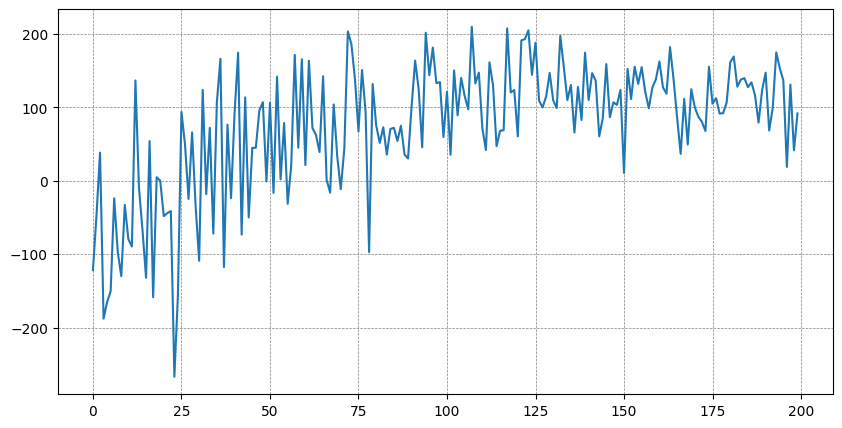

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(total_reward_history)
plt.grid(linestyle='--', linewidth=0.5, color='gray')

# inference test

In [363]:
net = torch.load(model_path, weights_only=False)

In [438]:
def select_best_action(net, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    logits, value = net(state)
    probs = torch.softmax(logits, dim=-1)
    action = torch.argmax(probs)
    return action.item(), probs[0][action], value

In [448]:
# inference
my_account = Account(3000000)
env = Environment(chart_df, value_df, my_account)
done = False

state = env.reset()

action_history = [0]
value_history = [0]

while not done:
    action, log_prob, value = select_best_action(net, state)
    next_state, reward, done = env.step(action, log_prob.item())
    state = next_state

    action_history.append(action)
    value_history.append(value.item())

In [449]:
my_account.portfolio_value

4491565.449999999

In [450]:
my_account.profitloss

0.4971884833333331

In [451]:
chart_df.loc[:, "action"] = [Action.TABLE[action] for action in action_history]
chart_df.loc[:, "value"] = value_history

/var/folders/bs/bk044_dn0zn5r8mbwn4k4dgw0000gn/T/ipykernel_4772/77473768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df["date"]=chart_df["date"].astype(str)


<Axes: xlabel='date', ylabel='close'>

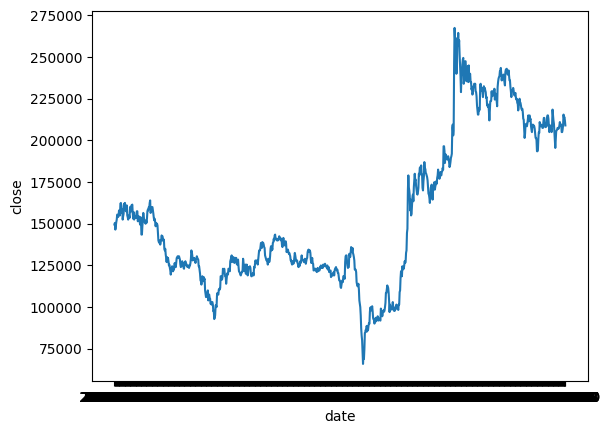

In [452]:
chart_df["date"]=chart_df["date"].astype(str)
sns.lineplot(data=chart_df, x="date", y="close")

<Axes: xlabel='date', ylabel='value'>

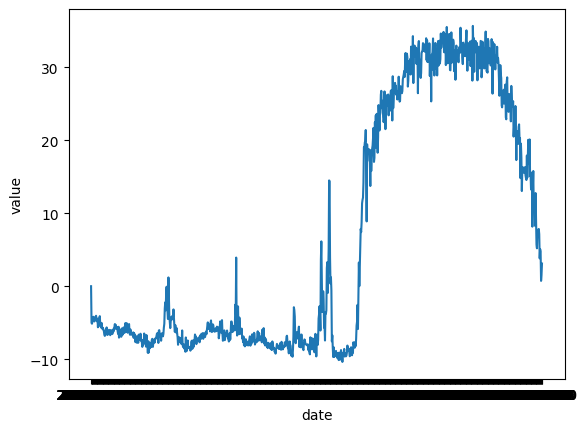

In [453]:
sns.lineplot(data=chart_df, x="date", y="value")

<Axes: xlabel='action', ylabel='close'>

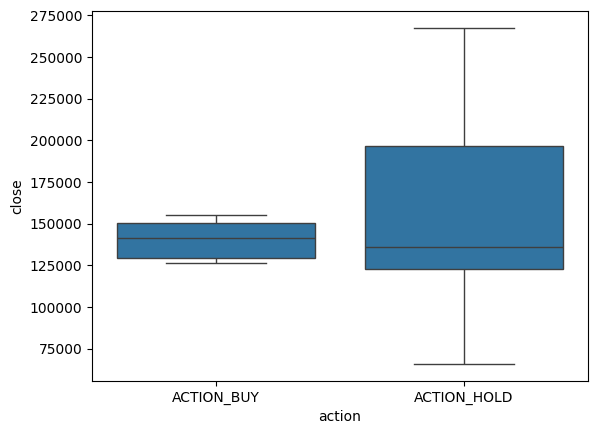

In [455]:
sns.boxplot(data=chart_df, x="action", y="close")

<Axes: xlabel='action', ylabel='close_nor'>

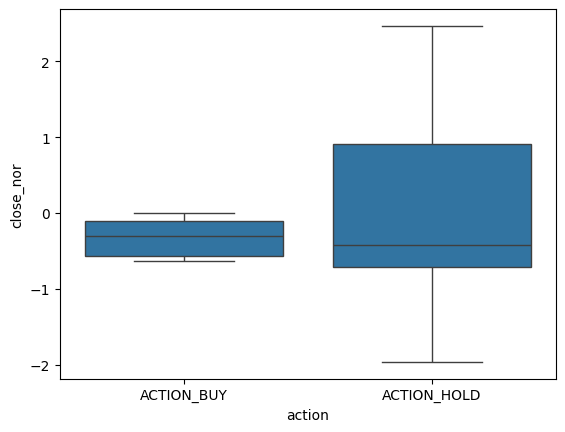

In [456]:
chart_df['close_nor'] = (chart_df['close'] - chart_df['close'].mean())/chart_df['close'].std()
sns.boxplot(data=chart_df, x="action", y="close_nor")